### Eigenvectors-based method

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set(font_scale=1.6)

In [3]:
x_0 = np.zeros(3)
x_0[0] = 1

In [4]:
lambda_ = 7.26*10**-5
gamma = 2.8 * 10**-5

In [5]:
A = np.zeros((3, 3))

A[0, 0] = -2*gamma - lambda_
A[0, 1] = 2*gamma
A[0, 2] = lambda_
A[1, 1] = -1 *(gamma+lambda_)
A[1, 2] = gamma + lambda_
A

array([[-1.286e-04,  5.600e-05,  7.260e-05],
       [ 0.000e+00, -1.006e-04,  1.006e-04],
       [ 0.000e+00,  0.000e+00,  0.000e+00]])

In [6]:
def get_e_At(t, A):
    w, S = np.linalg.eig(A)
    S_inv = np.linalg.inv(S)
    
    exp_t = np.exp(t*w)
    M = np.diag(exp_t)
    
    exp_At = np.dot(np.dot(S, M), S_inv)
    
    return exp_At

In [7]:
lb  = 0.0
ub = 80000
n_star = 5000+1
x_star = np.linspace(lb, ub, n_star)[1:]

In [8]:
%%time 

val = []
for t in x_star:
    e_At = get_e_At(t, A)
    MSS_reliability = np.dot(x_0, e_At)
    
    val.append(MSS_reliability)

Wall time: 190 ms


In [9]:
exact_solution_eigen_vectors = np.array(val)
exact_solution_eigen_vectors_df = pd.DataFrame(val, columns = ['state_0', 'state_1', 'state_2'])
exact_solution_eigen_vectors_df.to_csv("analytical_solution_by_eigenvector_method.csv", index=False)
exact_solution_eigen_vectors_df.head()

,state_0,state_1,state_2
0,0.997945,0.000894,0.001161
1,0.995893,0.001785,0.002321
2,0.993846,0.002673,0.003481
3,0.991803,0.003558,0.004639
4,0.989765,0.004439,0.005796


Text(0, 0.5, 'Probability')

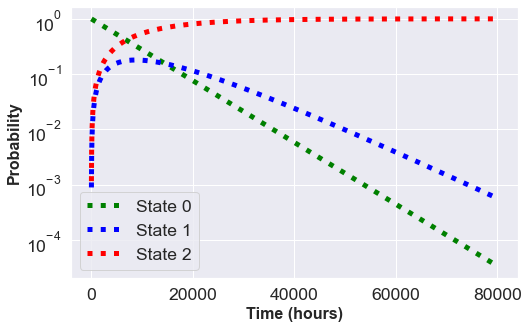

In [10]:
plt.figure(figsize=(8, 5))
sns.lineplot(x = x_star.flatten(), y = exact_solution_eigen_vectors[:, 0], label = 'State 0', linewidth = 5, color = 'green', 
             linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = exact_solution_eigen_vectors[:, 1], label = 'State 1', linewidth = 5, color = 'blue', 
             linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = exact_solution_eigen_vectors[:, 2], label = 'State 2', linewidth = 5, color = 'red', 
             linestyle='dotted')

plt.yscale('log')
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)

### Laplace transform-based method

In [24]:
from sympy import *
from sympy.matrices import Matrix, eye, zeros, ones, diag
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
gamma, lambda_ = symbols('gamma, lambda_')

In [26]:
A = Matrix([[-2*gamma - lambda_, 2*gamma, lambda_], [0, -1 *(gamma+lambda_), gamma+lambda_], [0, 0, 0]]);
A

Matrix([
[-2*gamma - lambda_,          2*gamma,         lambda_],
[                 0, -gamma - lambda_, gamma + lambda_],
[                 0,                0,               0]])

In [27]:
n = A.shape[0]

In [28]:
s = symbols('s')
t = symbols('t', positive=True)
s

s

In [29]:
I = eye(n)
I

Matrix([
[1, 0, 0],
[0, 1, 0],
[0, 0, 1]])

In [30]:
%%time

f = (s*I - A).inv()
f = simplify(f)
f

Wall time: 211 ms


Matrix([
[1/(2*gamma + lambda_ + s), 2*gamma/(2*gamma**2 + 3*gamma*lambda_ + 3*gamma*s + lambda_**2 + 2*lambda_*s + s**2), (2*gamma**2 + 3*gamma*lambda_ + lambda_**2 + lambda_*s)/(s*(2*gamma**2 + 3*gamma*lambda_ + 3*gamma*s + lambda_**2 + 2*lambda_*s + s**2))],
[                        0,                                                              1/(gamma + lambda_ + s),                                                                                              (gamma + lambda_)/(s*(gamma + lambda_ + s))],
[                        0,                                                                                    0,                                                                                                                                      1/s]])

In [31]:
%%time

F = inverse_laplace_transform(f, s, t)
F

Wall time: 4.49 s


Matrix([
[exp(-t*(2*re(gamma) + re(lambda_)) - I*t*(2*im(gamma) + im(lambda_))), (2*exp(t*(re(gamma) + I*im(gamma))) - 2)*exp(-t*(2*re(gamma) + re(lambda_) + 2*I*im(gamma) + I*im(lambda_))), (-2*exp(t*(re(gamma) + I*im(gamma))) + exp(t*(2*re(gamma) + re(lambda_) + 2*I*im(gamma) + I*im(lambda_))) + 1)*exp(-t*(2*re(gamma) + re(lambda_) + 2*I*im(gamma) + I*im(lambda_)))],
[                                                                    0,                                            exp(-t*(re(gamma) + re(lambda_)) - I*t*(im(gamma) + im(lambda_))),                                                                                                            1 - exp(-t*re(gamma) - t*re(lambda_) - I*t*im(gamma) - I*t*im(lambda_))],
[                                                                    0,                                                                                                            0,                                                                                    

In [32]:
lb  = 0.0
ub = 80000
n_star = 5000+1
x_star = np.linspace(lb, ub, n_star)[1:]

In [33]:
x_0 = np.zeros(3)
x_0[0] = 1

In [34]:
%%time 

lambda_val = 7.26*10**-5
gamma_val = 2.8 * 10**-5

val = []
for t_val in x_star:
    state_transition_matrix = np.array(F.subs([(gamma, gamma_val), (lambda_, lambda_val), (t, t_val)]))
    MSS_reliability = np.dot(x_0, state_transition_matrix)
    MSS_reliability = list(map(float, MSS_reliability))
    
    val.append(MSS_reliability)

Wall time: 23.3 s


In [35]:
exact_solution_Laplace = np.array(val)
exact_solution_Laplace_df = pd.DataFrame(val, columns = ['state_0', 'state_1', 'state_2'])
exact_solution_Laplace_df.to_csv("analytical_solution_by_laplace_method.csv", index=False)
exact_solution_Laplace_df.head()

,state_0,state_1,state_2
0,0.997945,0.000894,0.001161
1,0.995893,0.001785,0.002321
2,0.993846,0.002673,0.003481
3,0.991803,0.003558,0.004639
4,0.989765,0.004439,0.005796


Text(0, 0.5, 'Probability')

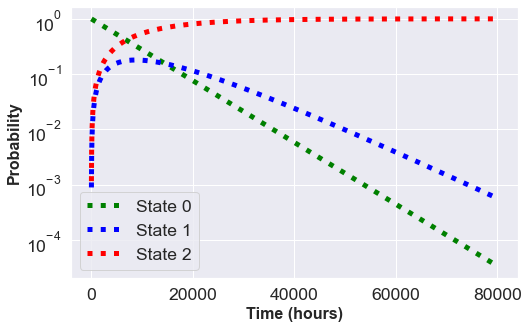

In [36]:
plt.figure(figsize=(8, 5))

sns.lineplot(x = x_star.flatten(), y = exact_solution_Laplace[:, 0], label = 'State 0', linewidth = 5, color = 'green', 
             linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = exact_solution_Laplace[:, 1], label = 'State 1', linewidth = 5, color = 'blue', 
             linestyle='dotted')
sns.lineplot(x = x_star.flatten(), y = exact_solution_Laplace[:, 2], label = 'State 2', linewidth = 5, color = 'red', 
             linestyle='dotted')

plt.yscale('log')
plt.xlabel("Time (hours)", fontdict=dict(weight='bold'), fontsize=16)
plt.ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)